# Demo of VAE for anomaly detection of diverse sensor data
Trained on non-fault data to learn a normal expectation.

Build the model for 512 time points per cycle with 14 sensors.

In [152]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [154]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [3]:
from IPython.core.debugger import set_trace

In [4]:
from demo import *
device

device(type='cuda', index=0)

In [5]:
desc

'accumulator'

In [6]:
model = VAE1D(size, n_channels, n_latent)
model = model.to(device)
print(f"Time-series size = {size}, number of sensors = {n_channels}, "
      f"latent size = {n_latent}")

Time-series size = 512, number of sensors = 14, latent size = 50


Load the best parameters from training.

In [7]:
model = load_checkpoint(model, device)

Checkpoint Performance:
Validation loss: 14.268
Epoch: 210


In [8]:
params = model.demo()

Input size: torch.Size([1, 14, 512])
Encoded size: torch.Size([1, 1024, 4])
Latent size: torch.Size([1, 50, 1])
Decoded (output) size: torch.Size([1, 14, 512])


In [9]:
X, E, L, D = [param.cpu().detach().numpy() for param in params]
MSE = np.power((X - D), 2).sum() / 2
print(f"MSE of random data = {MSE:.3f}")

MSE of random data = 665.316


In [10]:
X[:, :4, :4]

array([[[0.4477136 , 0.2949479 , 0.8867511 , 0.35524344],
        [0.8903849 , 0.19120984, 0.49234584, 0.08286102],
        [0.83596766, 0.8958806 , 0.46007675, 0.45216814],
        [0.52077913, 0.92631006, 0.47041044, 0.02704717]]], dtype=float32)

In [11]:
D[:, :4, :4]

array([[[ 0.20187737,  0.19564557,  0.2211503 ,  0.33983058],
        [ 0.34558877,  0.12649533,  0.04529643, -0.00835324],
        [ 0.5201075 ,  0.40225142,  0.39519426,  0.31591797],
        [ 0.23245442,  0.3578172 ,  0.37661207,  0.6136845 ]]],
      dtype=float32)

Next we need to load the datasets of sensors readings.

In [12]:
data_path = Path(f'data/hydraulic/{desc}')
train_dl, val_dl, test_dl = load_datasets(data_path)

In [13]:
print(len(train_dl), len(val_dl), len(test_dl))

27 7 1157


Let's get some random samples from the dataset for examples and generate new versions.

In [14]:
data, targets = get_random_samples(test_dl)

In [15]:
classes = list_target_classes(test_dl)

0 = fail
1 = norm


In [16]:
targets = targets.cpu().numpy()
targets[:10]

array([0, 0, 0, 1, 0, 1, 0, 0, 0, 0])

In [17]:
print('normals = ', targets.sum())

normals =  349


In [18]:
print('failures = ', len(targets) - targets.sum())

failures =  808


In [19]:
criterion = VAE1DLoss()
criterion = criterion.to(device)

In [20]:
model.eval()
with torch.no_grad():
    # Generate
    data = data.to(device)
    gen_data, mu, logvar = model(data)
    loss, loss_desc = criterion(gen_data, data, mu, logvar, reduce=False)
    

In [21]:
gen_err = -loss_desc['logp']
gen_err[:10]

tensor([ 1.7576, 53.0600,  2.1154,  3.9802,  1.8256, 13.2044,  1.6972,  3.6315,
         2.5106, 21.4270], device='cuda:0')

[[ 0.01716174 -0.00078174 -0.00013807  0.01029831 -0.00608581]
 [-0.05318646 -0.00163958  0.01154005  0.01182889  0.02192367]
 [ 0.07319486  0.0256806   0.01902932  0.09147477  0.08312827]
 [ 0.06907581  0.01849836  0.0894357   0.0693112   0.13555914]
 [ 0.06273419 -0.02140195 -0.00197036 -0.04470071 -0.04519095]]
MSE = 1.7575924396514893


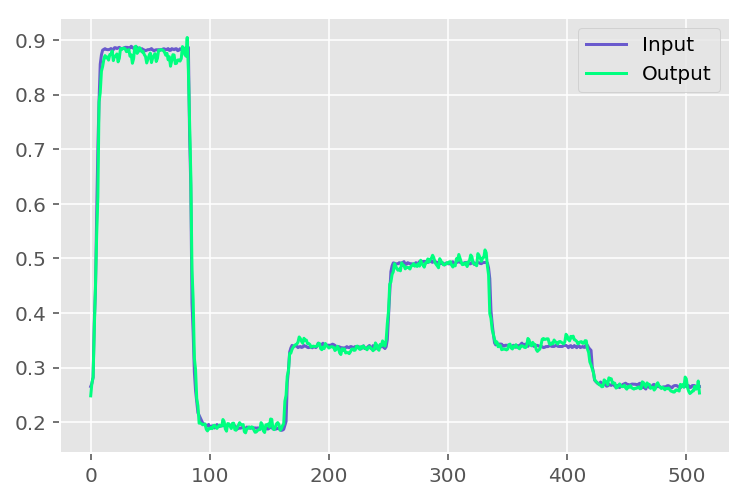

In [177]:
idx = 0
sample = data[idx, :, :].cpu().numpy()
gen_sample = gen_data[idx, :, :].cpu().numpy()
plt.plot(sample[0, :], label='Input', c='slateblue')
plt.plot(gen_sample[0, :], label='Output', c='springgreen')
plt.legend()
print(sample[:5, :5] - gen_sample[:5, :5])
print(f"MSE = {np.power((sample - gen_sample), 2).sum() / 2}")

[[ 0.01716174 -0.00078174 -0.00013807  0.01029831 -0.00608581]
 [-0.05318646 -0.00163958  0.01154005  0.01182889  0.02192367]
 [ 0.07319486  0.0256806   0.01902932  0.09147477  0.08312827]
 [ 0.06907581  0.01849836  0.0894357   0.0693112   0.13555914]
 [ 0.06273419 -0.02140195 -0.00197036 -0.04470071 -0.04519095]]
MSE = 1.7575924396514893


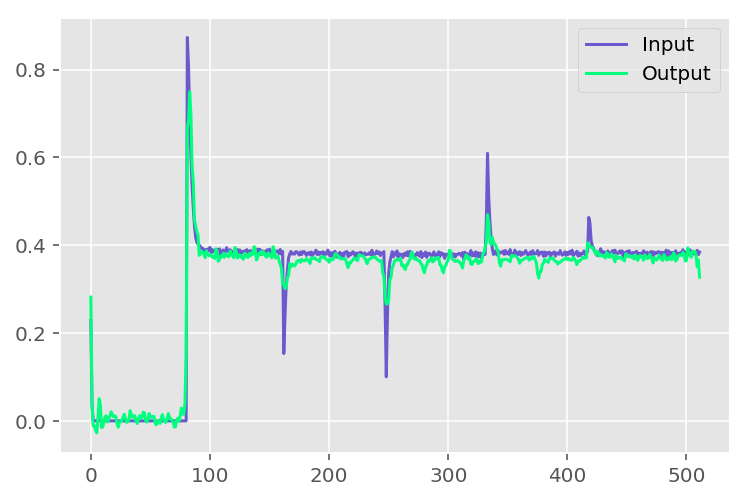

In [178]:
idx = 0
sample = data[idx, :, :].cpu().numpy()
gen_sample = gen_data[idx, :, :].cpu().numpy()
plt.plot(sample[1, :], label='Input', c='slateblue')
plt.plot(gen_sample[1, :], label='Output', c='springgreen')
plt.legend()
print(sample[:5, :5] - gen_sample[:5, :5])
print(f"MSE = {np.power((sample - gen_sample), 2).sum() / 2}")

In [24]:
err = np.zeros(targets.shape)
for i, target in enumerate(targets):
    err[i] = -loss_desc['logp'][i]
    print(f"Target = {target}, MSE = {err[i]:.3f}")
    if i > 10:
        break

Target = 0, MSE = 1.758
Target = 0, MSE = 53.060
Target = 0, MSE = 2.115
Target = 1, MSE = 3.980
Target = 0, MSE = 1.826
Target = 1, MSE = 13.204
Target = 0, MSE = 1.697
Target = 0, MSE = 3.631
Target = 0, MSE = 2.511
Target = 0, MSE = 21.427
Target = 0, MSE = 21.659
Target = 1, MSE = 1.962


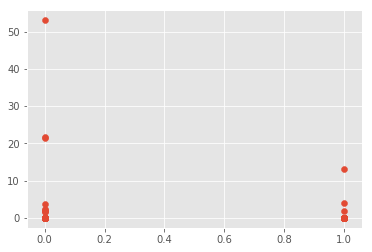

In [25]:
plt.scatter(targets, err)

Show the data plots.

Let's score the success of the recreation and look for outliers.

In [27]:
scores = score(test_dl, model, criterion)

100%|██████████| 1157/1157 [00:07<00:00, 150.76it/s]


In [28]:
test_means = pd.DataFrame()
for (name, cls), item in scores.items():
    test_means.loc[name, cls] = np.array(item).mean()

print("###################### TEST MEANS #####################")
print(test_means)

###################### TEST MEANS #####################
            fail       norm
loss   74.618190  42.801638
KL     59.392421  33.932409
error  15.225768   8.869229


In [29]:
val_means = pd.DataFrame()
for (name, cls), item in score(val_dl, model, criterion).items():
    val_means.loc[name, cls] = np.array(item).mean()

print("###################### VAL MEANS #####################")
print(val_means)

100%|██████████| 7/7 [00:01<00:00,  5.62it/s]

###################### VAL MEANS #####################
            norm
loss   46.339574
KL     33.759508
error  12.580065


In [30]:
train_means = pd.DataFrame()
for (name, cls), item in score(train_dl, model, criterion).items():
    train_means.loc[name, cls] = np.array(item).mean()

print("###################### TRAIN MEANS #####################")
print(train_means)

100%|██████████| 27/27 [00:04<00:00,  5.95it/s]

###################### TRAIN MEANS #####################
            norm
loss   40.934643
KL     33.403532
error   7.531111


Let's calculate AUC to judge performance.

In [31]:
scores.keys()

dict_keys([('loss', 'fail'), ('loss', 'norm'), ('KL', 'fail'), ('KL', 'norm'), ('error', 'fail'), ('error', 'norm')])

In [32]:
print(len(scores[('error', 'norm')]), len(scores[('error', 'fail')]))

349 808


In [33]:
# simple definition of the threshold as mean between sets
threshold = (np.mean(scores['error', 'fail']) +
             np.mean(scores['error', 'norm'])) / 2
print('mean threshold:', threshold)
# maximum 95% percentile of normal as threshold
# threshold = np.percentile(scores['error', 'norm'], 95)
# print('95th percentile threshold:', threshold)

mean threshold: 12.047498610662569


In [34]:
t_scores = scores.copy()
t_scores[('error', 'fail')] = (t_scores[('error', 'fail')] > threshold)
t_scores[('error', 'norm')] = (t_scores[('error', 'norm')] > threshold)

t_score = []
t_score.extend(t_scores[('error', 'fail')])
t_score.extend(t_scores[('error', 'norm')])
t_score = np.array(t_score)

y_true = []
y_true.extend([True] * len(t_scores[('error', 'fail')]))
y_true.extend([False] * len(t_scores[('error', 'norm')]))
y_true = np.array(y_true)

In [35]:
t_corr = t_score == y_true
t_corr.sum() / len(t_corr)

0.5315471045808124

In [36]:
f1_score(y_true, t_score)

0.555008210180624

In [37]:
auc_scores = auc_score(test_dl, t_scores)
auc_scores

0.6060065533774007

In [38]:
np.mean(scores['error', 'norm'])

8.869228826040525

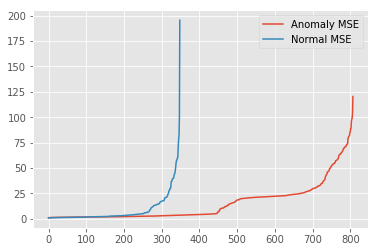

In [55]:
normaly = sorted(scores[('error', 'norm')])
anomaly = sorted(scores[('error', 'fail')])
plt.plot(anomaly, label='Anomaly MSE')
plt.plot(normaly, label='Normal MSE')
plt.legend()

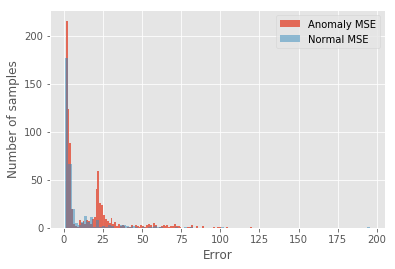

In [71]:
plt.hist(anomaly, label='Anomaly MSE', bins=100, alpha=0.8)
plt.hist(normaly, label='Normal MSE', bins=100, alpha=0.5)
plt.xlabel('Error')
plt.ylabel('Number of samples')
plt.legend()

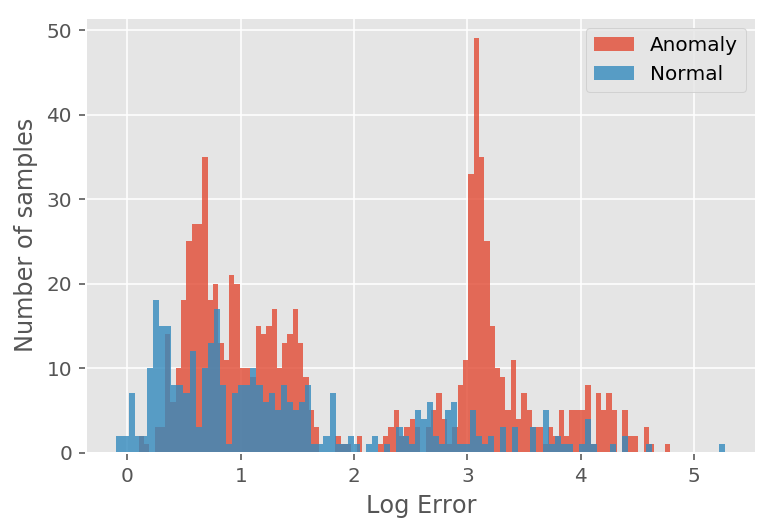

In [158]:
# With log values
plt.hist(np.log(anomaly), label='Anomaly', bins=100, alpha=0.8)
plt.hist(np.log(normaly), label='Normal', bins=100, alpha=0.8)
plt.xlabel('Log Error')
plt.ylabel('Number of samples')
plt.legend()

In [44]:
normalx = np.random.rand(len(normaly))
anomalx = np.random.rand(len(anomaly))

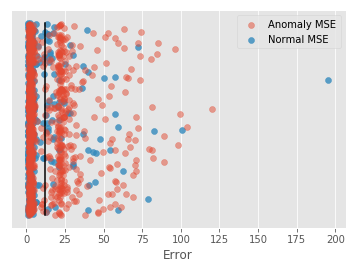

In [69]:
plt.scatter(anomaly, anomalx, label='Anomaly',
            alpha=0.5, zorder=2)
plt.scatter(normaly, normalx, label='Normal',
            alpha=0.8)
plt.plot([threshold, threshold], [0, 1], 'k-')
plt.gca().get_yaxis().set_visible(False)
plt.xlabel('Error')
plt.legend()

Try fitting a normal distribution to the validation MSE to define a threshold.

In [74]:
val_scores = score(val_dl, model, criterion)

100%|██████████| 7/7 [00:01<00:00,  4.92it/s]


In [75]:
val_scores.keys()

dict_keys([('loss', 'norm'), ('KL', 'norm'), ('error', 'norm')])

[0.9524115324020386, 1.074782371520996, 1.0888280868530273, 1.0993608236312866, 1.1089272499084473]
mean=12.58, stdev=65.73


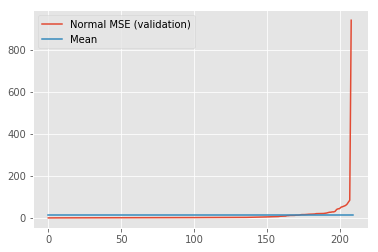

In [76]:
val_norm = sorted(val_scores[('error', 'norm')])
print(val_norm[:5])
mean = np.mean(val_norm)
std = np.std(val_norm)
print('mean={:.2f}, stdev={:.2f}'.format(mean, std))
plt.plot(val_norm, label= 'Normal MSE (validation)')
plt.plot([0, len(val_norm)], [mean, mean], label='Mean')
plt.legend()

Implement PCA to visualize the latent space.

In [180]:
latents, targets = compute_latent(test_dl, model)

100%|██████████| 1157/1157 [00:07<00:00, 151.83it/s]


In [181]:
from sklearn.decomposition import PCA

In [182]:
pca = PCA(n_components=2)

In [183]:
lat_pca = pca.fit_transform(latents)

In [184]:
lat_pca.shape

(1157, 2)

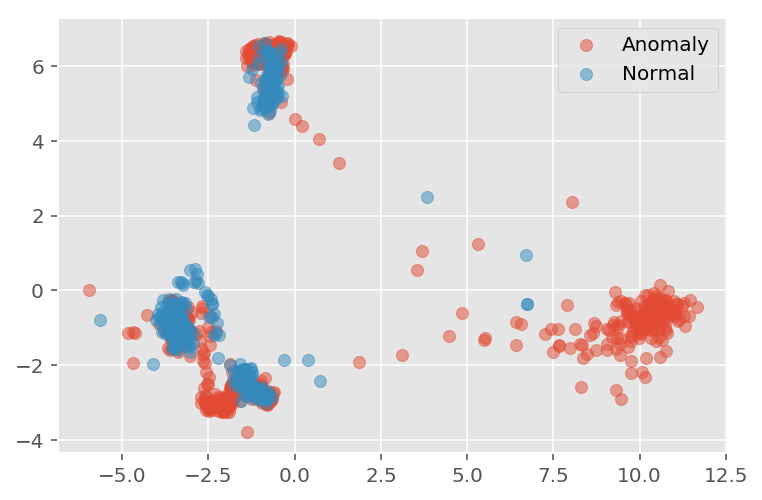

In [185]:
fail_mask = targets == 0
norm_mask = targets == 1
plt.scatter(lat_pca[fail_mask, 0], lat_pca[fail_mask, 1],
           label='Anomaly', alpha=0.5)
plt.scatter(lat_pca[norm_mask, 0], lat_pca[norm_mask, 1],
            label='Normal', alpha=0.5)
plt.legend()

In [83]:
pca.explained_variance_ratio_

array([0.4173073 , 0.24080807], dtype=float32)

Cluster the latent space into kmeans clusters.

In [84]:
from sklearn.cluster import KMeans

In [85]:
kmeans = KMeans(3)

In [86]:
lat_k = kmeans.fit_transform(latents)

In [87]:
lat_k.shape

(1157, 3)

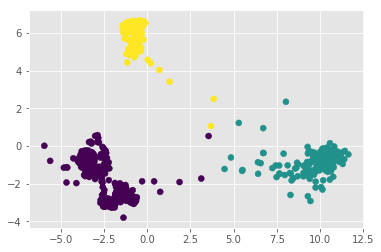

In [94]:
plt.scatter(lat_pca[:, 0], lat_pca[:, 1], c=kmeans.labels_)

Try adding the error terms to the latent features.

In [95]:
latents, kl, error, targets = compute_latent_and_loss(test_dl, model, criterion)

100%|██████████| 1157/1157 [00:07<00:00, 147.09it/s]


In [96]:
print(latents.shape, kl.shape, error.shape, targets.shape)

(1157, 50) (1157,) (1157,) (1157,)


In [97]:
features = np.hstack([latents, kl[:, None], error[:, None]])
features.shape

(1157, 52)

In [98]:
pca = PCA(n_components=2)
lat_pca = pca.fit_transform(features)
lat_pca.shape

(1157, 2)

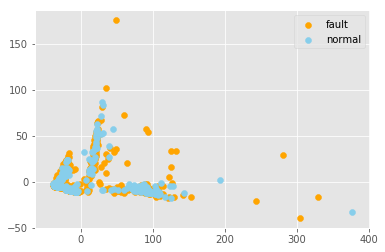

In [99]:
plt.scatter(lat_pca[fail_mask, 0], lat_pca[fail_mask, 1],
            c='orange', label='fault')
plt.scatter(lat_pca[norm_mask, 0], lat_pca[norm_mask, 1],
            c='skyblue', label='normal')
plt.legend()

In [100]:
pca.explained_variance_ratio_

array([0.89009171, 0.09906391])

Compare the pca plots for validation and training sets.

100%|██████████| 27/27 [00:04<00:00,  6.08it/s]


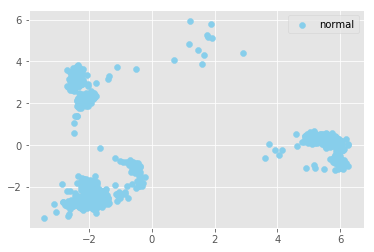

In [101]:
latents, targets = compute_latent(train_dl, model)
pca = PCA(n_components=2)
lat_pca = pca.fit_transform(latents)
plt.scatter(lat_pca[:, 0], lat_pca[:, 1],
            c='skyblue', label='normal')
plt.legend()

100%|██████████| 7/7 [00:01<00:00,  5.65it/s]


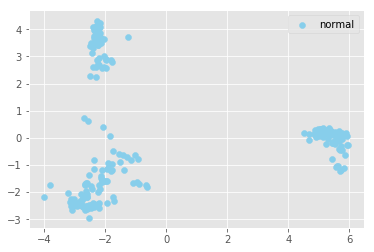

In [102]:
latents, targets = compute_latent(val_dl, model)
pca = PCA(n_components=2)
lat_pca = pca.fit_transform(latents)
plt.scatter(lat_pca[:, 0], lat_pca[:, 1],
            c='skyblue', label='normal')
plt.legend()

Combine the validation plot with the test plot to understand global structure.

In [103]:
latents, targets = compute_latent(train_dl, model)
pca = PCA(n_components=2)
train_pca = pca.fit_transform(latents)

100%|██████████| 27/27 [00:04<00:00,  6.07it/s]


In [104]:
latents, targets = compute_latent(val_dl, model)
val_pca = pca.transform(latents)

100%|██████████| 7/7 [00:01<00:00,  5.67it/s]


In [105]:
latents, targets = compute_latent(test_dl, model)
test_pca = pca.transform(latents)
fail_mask = targets == 0
norm_mask = targets == 1

100%|██████████| 1157/1157 [00:07<00:00, 157.53it/s]


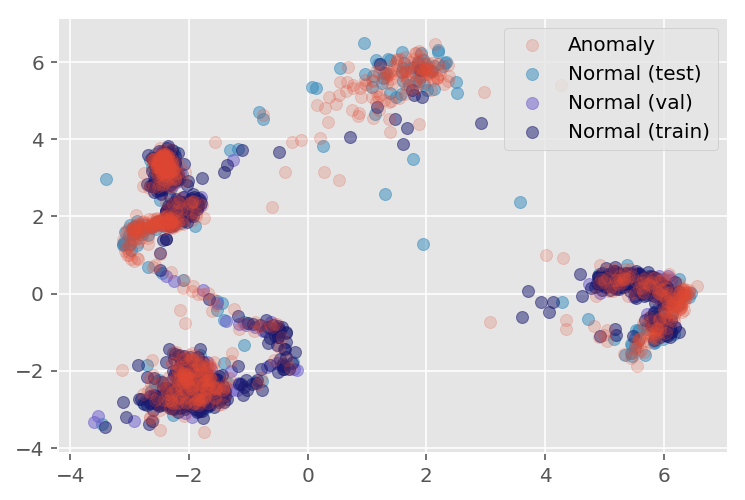

In [187]:
plt.scatter(test_pca[fail_mask, 0], test_pca[fail_mask, 1],
            label='Anomaly', alpha=0.2, zorder=2)
plt.scatter(test_pca[norm_mask, 0], test_pca[norm_mask, 1],
            label='Normal (test)', alpha=0.5)
plt.scatter(val_pca[:, 0], val_pca[:, 1],
            c='slateblue', label='Normal (val)', alpha=0.5)
plt.scatter(train_pca[:, 0], train_pca[:, 1],
            c='midnightblue', label='Normal (train)', alpha=0.5)
plt.legend()

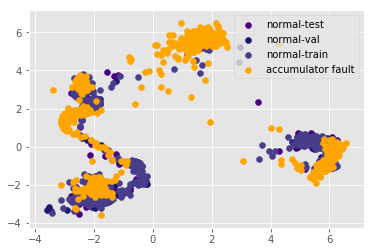

In [107]:
plt.scatter(test_pca[norm_mask, 0], test_pca[norm_mask, 1],
            c='indigo', label='normal-test')
plt.scatter(val_pca[:, 0], val_pca[:, 1],
            c='midnightblue', label='normal-val')
plt.scatter(train_pca[:, 0], train_pca[:, 1],
            c='darkslateblue', label='normal-train')
plt.scatter(test_pca[fail_mask, 0], test_pca[fail_mask, 1],
            c='orange', label=desc + ' fault')
plt.legend()

Get an example of a fault plot and a normal plot.

In [146]:
f_ex = None
n_ex = None
for X, y in test_dl:
    if y == 0 and f_ex is None:
        f_ex = X[0, :, :].cpu().detach().numpy()
    if y == 1 and n_ex is None:
        n_ex = X[0, :, :].cpu().detach().numpy()
    if f_ex is not None and n_ex is not None:
        break
print(f_ex.shape, n_ex.shape)

(14, 512) (14, 512)


(-25.55, 536.55, -0.049771785736083984, 1.0452075004577637)

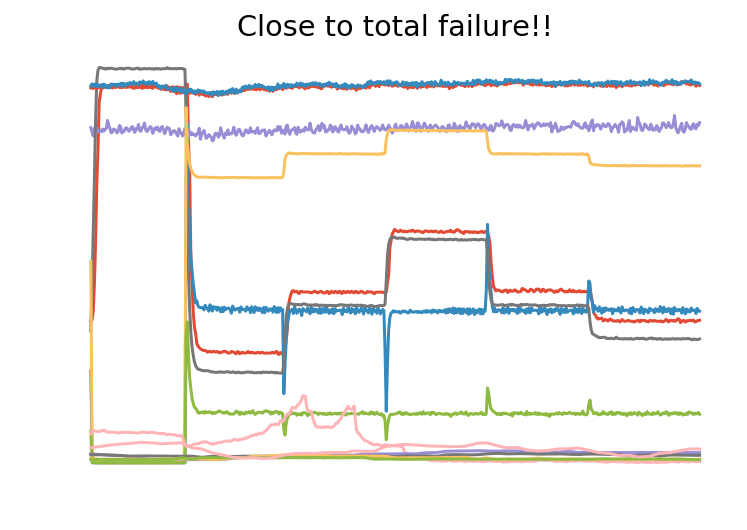

In [155]:
for i in range(f_ex.shape[0]):
    plt.plot(f_ex[i, :])
plt.title('Close to total failure!!')
plt.axis('off')

(-25.55, 536.55, -0.04970162212848664, 1.0437340646982194)

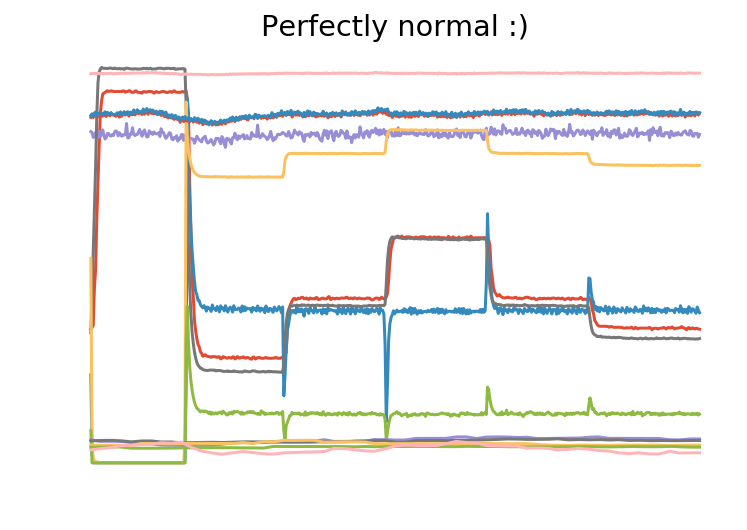

In [156]:
for i in range(n_ex.shape[0]):
    plt.plot(n_ex[i, :])
plt.title('Perfectly normal :)')
plt.axis('off')